In [1]:
import pandas as pd
import numpy as np

# unknown and 999 should be treated as missing values
df = pd.read_csv('bank-additional-full.csv', sep = ';', na_values = ['unknown' ,999])
df = df.drop(columns = ['duration']) # drop future information
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
print(df.shape)
print(df.dtypes)

(41188, 20)
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays             float64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [14]:
# deal with campaign
# number of contacts performed during this campaign for this client (including the last contact)
df['ncalls'] = df['campaign'] - 1
df = df.drop(columns = ['campaign'])
# since campaign includes the last contact, we want to create a new feature to indicate the number of calls made to one client
# the last contact is future information

In [ ]:
# check iid
# number of contacts performed during this campaign for this client (including last contact)
# independent
df


In [ ]:
# check if imbalanced
print(np.unique(df.y, return_counts = True)) # yes takes up 11%
# 11% is not too bad, we will determine if using stratification during splitting
sum(df.y == 'yes') / df.shape[0]

In [ ]:
# check missing values
perc_missing_per_ftr = df.isnull().sum(axis = 0) / df.shape[0]
print('Fraction of Missing Values in Features:') 
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data Types of the Features with Missing Values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(df.isnull().sum(axis = 1) != 0) / df.shape[0]
print('Fraction of Rows with Missing Values:', frac_missing)

In [ ]:
# train_test_split
random_state = 42


In [24]:
# preprocessing
# numerical: age, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, campiagn
# categorical: job, martial, default, housing, loan, contact
# ordinal: education, month, day_of_week, poutcome
cat_ftrs = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

ordinal_ftrs = ['education', 'month', 'day_of_week']
ordinal_cats = [['NA', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree'],
                ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
                ['mon', 'tue', 'wed', 'thu', 'fri']]

num_ftrs = ['age', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'ncalls']

In [25]:
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

random_state = 42

# one-hot encoder
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy = 'constant', fill_value = 'NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [26]:
# splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
X = df.drop(columns = 'y')
y = df['y'] # this is a classification problem

# test set
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Test Set:', X_test.shape, y_test.shape)
print('\n')

# KFold
n_splits = 10
kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)
for train_index, val_index in kf.split(X_other,y_other):
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]

    # preprocessor
    # fit_transform the training set
    X_prep = preprocessor.fit_transform(X_train)
    feature_names = preprocessor.get_feature_names_out()
    df_train = pd.DataFrame(data = X_prep, columns = feature_names)
    print(df_train.shape)


    # transform the validation set
    df_val = preprocessor.transform(X_val)
    df_val = pd.DataFrame(data = df_val, columns = feature_names)
    print(df_val.shape)
    perc_missing_per_ftr = df_val.isnull().sum(axis=0)/df_val.shape[0]
    print('Fraction of Missing Values in Features:')
    print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    print('Data Types of the Features with Missing Values:')
    print(df_val[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
    frac_missing = sum(df_val.isnull().sum(axis=1)!=0)/df_val.shape[0]
    print('Fraction of Points with Missing Values:',frac_missing)

    print('\n')

# transform the test set
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data = df_test, columns = feature_names)
print(df_test.shape)
print(feature_names)
print(len(feature_names))

Test Set: (8238, 19) (8238,)


(29655, 42)
(3295, 42)
Fraction of Missing Values in Features:
num__pdays    0.961153
dtype: float64
Data Types of the Features with Missing Values:
num__pdays    float64
dtype: object
Fraction of Points with Missing Values: 0.9611532625189682


(29655, 42)
(3295, 42)
Fraction of Missing Values in Features:
num__pdays    0.96176
dtype: float64
Data Types of the Features with Missing Values:
num__pdays    float64
dtype: object
Fraction of Points with Missing Values: 0.9617602427921093


(29655, 42)
(3295, 42)
Fraction of Missing Values in Features:
num__pdays    0.960546
dtype: float64
Data Types of the Features with Missing Values:
num__pdays    float64
dtype: object
Fraction of Points with Missing Values: 0.960546282245827


(29655, 42)
(3295, 42)
Fraction of Missing Values in Features:
num__pdays    0.964188
dtype: float64
Data Types of the Features with Missing Values:
num__pdays    float64
dtype: object
Fraction of Points with Missing Values: 0.964188

In [ ]:
# check missing values
print('Data Dimensions:',df_test.shape)

perc_missing_per_ftr = df_test.isnull().sum(axis = 0) / df_test.shape[0]
print('Fraction of Missing Values in Features:') 
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

print('Data Types of the Features with Missing Values:')
print(df_test[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)

frac_missing = sum(df_test.isnull().sum(axis = 1) != 0) / df_test.shape[0]
print('Fraction of Rows with Missing Values:', frac_missing)

In [ ]:
X_corr = df_train.corr()
import seaborn as sns
sns.heatmap(X_corr).set(title = 'Correlation Heatmap',xlabel = 'Features', ylabel = 'Features')


y             no   yes
contact               
cellular   22291  3853
telephone  14257   787


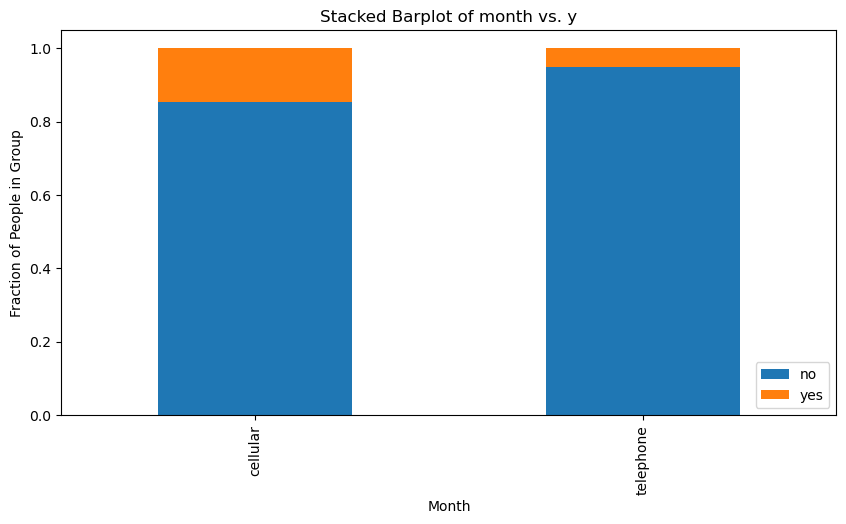

In [11]:
from matplotlib import pylab as plt
count_matrix = df.groupby(['contact', 'y']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0) #print(count_matrix_norm)

count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,5)) 
plt.ylabel('Fraction of People in Group')
plt.xlabel('Month')
plt.legend(loc=4)
plt.title('Stacked Barplot of month vs. y')
plt.show()

In [ ]:
df1 = df[(df.y == 'yes')]
df1
plt.figure(figsize=(5,3)) 
pd.value_counts(df1['housing']).plot.bar() 
plt.ylabel('count')
plt.xlabel('education level')

In [ ]:
df[['ncalls','y']].boxplot(by='y',figsize=(5,3))
plt.show()

In [28]:
# age, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, campiagn
df_num = df[['age', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'ncalls']]

In [ ]:
sns.boxplot(data = df_num)
plt.figure(figsize=(40,10)) 
plt.show()

[Text(0.5, 1.0, 'Boxplot of Continuous Features'),
 Text(0.5, 0, 'Features'),
 Text(0, 0.5, 'Values')]

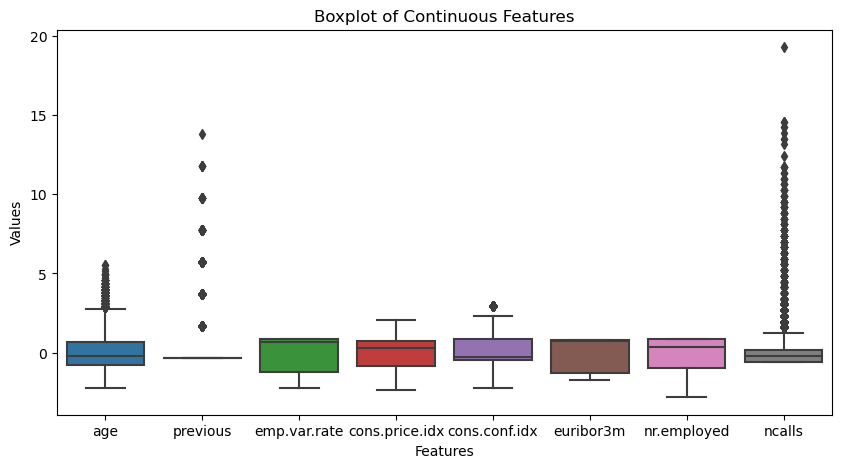

In [33]:
scaler = StandardScaler()
datanum_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns)
plt.figure(figsize=(10, 5))
sns.boxplot(data = datanum_scaled).set(title = 'Boxplot of Continuous Features', xlabel = 'Features', ylabel = 'Values')

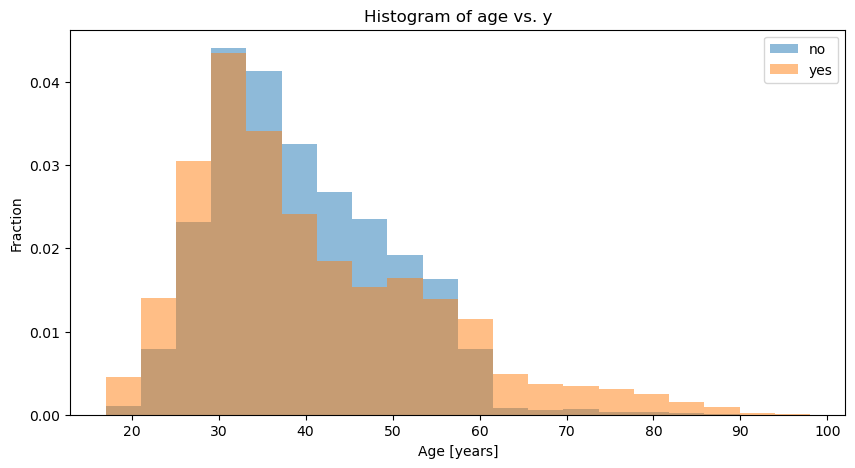

In [9]:
categories = df['y'].unique() 
bin_range = (df['age'].min(),df['age'].max())
plt.figure(figsize=(10,5))
for c in categories: plt.hist(df[df['y']==c]['age'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend() 
plt.ylabel('Fraction') 
plt.xlabel('Age [years]') 
plt.title('Histogram of age vs. y')
plt.show()

In [ ]:
df['y'] = df['y'].replace({'yes': 1, 'no': 0})
plt.pie(df.y)
plt.show()

In [ ]:
labels = 'Yes', 'No'
sizes = [sum(df.y == 'yes') / df.shape[0], sum(df.y == 'no') / df.shape[0]]
fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal') 
ax.legend(labels, loc='upper right')
ax.set_title('Balance of y')

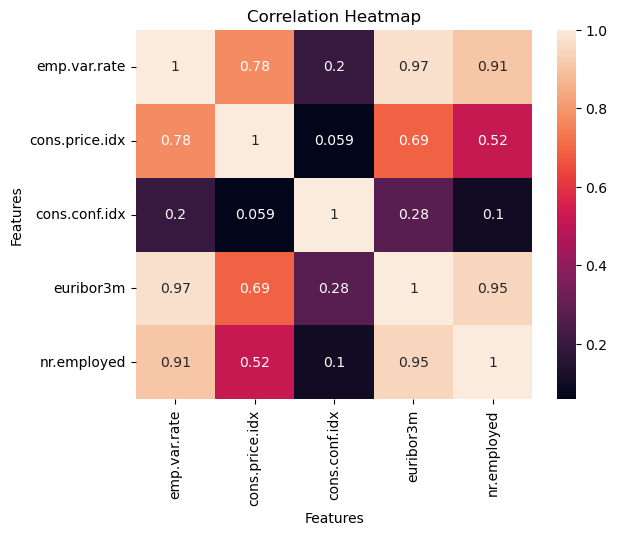

In [22]:
df_num = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
            'euribor3m', 'nr.employed']]
num_corr = df_num.corr()
num_corr
import seaborn as sns
sns.heatmap(num_corr, annot = True).set(title = 'Correlation Heatmap',xlabel = 'Features', ylabel = 'Features')
plt.show()

In [23]:
df['emp.var.rate'].unique()

array([ 1.1,  1.4, -0.1, -0.2, -1.8, -2.9, -3.4, -3. , -1.7, -1.1])